<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#Log-reg" data-toc-modified-id="Log-reg-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Log reg</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Clusterization" data-toc-modified-id="Clusterization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Clusterization</a></span><ul class="toc-item"><li><span><a href="#PCA" data-toc-modified-id="PCA-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#t-SNE" data-toc-modified-id="t-SNE-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>t-SNE</a></span></li><li><span><a href="#UMAP" data-toc-modified-id="UMAP-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>UMAP</a></span></li><li><span><a href="#K-Means" data-toc-modified-id="K-Means-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>K-Means</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm

## Data

In [2]:
df = pd.read_csv('../data/transactions_train.csv')

In [3]:
df = df.sort_values(['client_id', 'trans_date'])

In [4]:
bins = pd.read_csv('../data/train_target.csv')

In [5]:
df = pd.merge(df, bins, on='client_id')

In [6]:
print('before downsampling:\n', df.dtypes)
df['client_id'] = pd.to_numeric(df['client_id'], downcast='unsigned')
df['trans_date'] = pd.to_numeric(df['trans_date'], downcast='unsigned')
df['small_group'] = pd.to_numeric(df['small_group'], downcast='signed')
df['amount_rur'] = pd.to_numeric(df['amount_rur'], downcast='float')

print('after downsampling:\n',df.dtypes)

before downsampling:
 client_id        int64
trans_date       int64
small_group      int64
amount_rur     float64
bins             int64
dtype: object
after downsampling:
 client_id       uint16
trans_date      uint16
small_group      int16
amount_rur     float32
bins             int64
dtype: object


In [7]:
groups = pd.read_csv('../data/small_group_description.csv')

In [8]:
df['weekday'] = df['trans_date'] % 7

## EDA

In [9]:
np.random.seed(228)

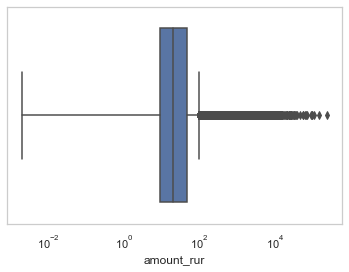

In [302]:
sns.boxplot(x=df['amount_rur'].sample(1000000))
plt.xscale('log')

In [304]:
len(df)

25897264

In [312]:
2428984/len(df)*100

9.379307404828555

Text(0.5, 1.0, 'Supermarkets transaction amount')

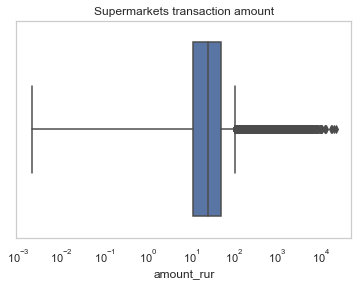

In [315]:
sns.boxplot(x=df[df['small_group'] == 1]['amount_rur'])
plt.xscale('log')
plt.title('Supermarkets transaction amount')

In [303]:
tmp = df.groupby('small_group')[['amount_rur']].agg(['mean', 'count', 'max', 'min']).reset_index()
tmp.columns =['small_group_code', 'mean', 'count', 'max', 'min']
tmp = tmp.set_index('small_group_code')
tmp = tmp.join(groups, on='small_group_code', how='outer').reset_index(drop=True)
tmp = tmp.sort_values('count', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
1,41.666897,8131374.0,22447.980469,0.002,Сетевые супермаркеты и продуктовые магазины,1
9,21.339022,3202881.0,11515.068359,0.001,Фастфуд и кафе,11
3,19.819042,2428984.0,24261.560547,0.001,Оплата телефона и связи,3
13,21.617123,1427077.0,13318.199219,0.005,Несетевые супермаркеты и продуктовые магазины,15
4,34.616478,1207604.0,38081.308594,0.001,Аптеки,4
...,...,...,...,...,...,...
199,NaN,NaN,NaN,NaN,Услуги починки (металлические изделия),199
200,NaN,NaN,NaN,NaN,Телеграф,200
201,NaN,NaN,NaN,NaN,Мануальные терапевты,201
202,NaN,NaN,NaN,NaN,Скорая помощь,202


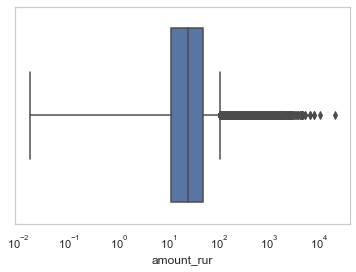

In [12]:
mask = df['small_group'] == 1
sns.boxplot(x=df[mask]['amount_rur'])
plt.xscale('log')

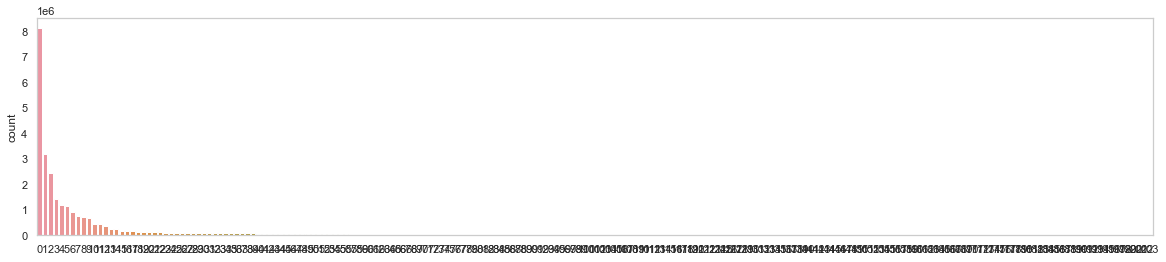

In [13]:
fig, axs = plt.subplots(figsize=(20, 4))

sns.barplot(x=list(range(len(tmp))), y=tmp['count'].sort_values(ascending=False));

In [14]:
quantiles = np.arange(0.1, 1.1, 0.1)
counts = [int(tmp['count'].quantile(i)) for i in quantiles]
quantiles = pd.DataFrame({'quantile': quantiles, 'count': counts})
quantiles

,quantile,count
0,0.1,34
1,0.2,183
2,0.3,516
3,0.4,1174
4,0.5,3287
5,0.6,11474
6,0.7,23829
7,0.8,61634
8,0.9,121845
9,1.0,8131374


In [15]:
tmp = tmp.sort_values('mean', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
173,1352.014282,100.0,9793.549805,0.824,Металлопрокат,173
170,1344.033936,209.0,7440.359863,1.294,Окна и двери,170
181,1275.825684,73.0,16371.612305,0.190,Прочие отели (аппартаменты),181
178,1187.892944,38.0,13553.929688,3.450,Камины и печи,178
190,1180.543213,28.0,9159.056641,4.579,Услуги починки (кондиционеры и холодильники),190
...,...,...,...,...,...,...
115,17.517340,19657.0,2426.331055,0.043,"Видео (онлайн-кинотеатры, онлайн-каналы, видео...",115
47,14.888980,37602.0,1831.812012,0.043,Пекарня,47
196,12.542286,7.0,29.863001,4.313,Ортопедия,197
202,NaN,NaN,NaN,NaN,Снегоходы,194


In [317]:
tmp = tmp.sort_values('mean', ascending=False)
tmp[:30]

,mean,count,max,min,small_group,small_group_code
5,803.790100,81212.0,128202.882812,0.043,Авиабилеты,5
12,800.021484,28905.0,284318.687500,0.014,Автодилеры и автосервис,14
11,555.444763,58504.0,129145.585938,0.002,"Прочие отели (а также airbnb, booking)",13
55,391.396545,45405.0,319685.687500,0.043,Аксессуары (драгоценности и часы),80
39,317.837799,89631.0,64203.664062,0.009,Мебель и товары для дома,46
25,286.354675,129043.0,88108.882812,0.043,Бытовая техника; компьютерная техника; мобильн...,28
37,250.337555,34669.0,39049.335938,0.002,Размещение рекламы,44
35,234.133469,92313.0,132256.812500,0.043,Одежда и аксессуары,39
44,222.269562,50203.0,31597.687500,0.025,Спортивные и фитнес-клубы,54
19,221.938492,121548.0,219405.437500,0.009,Больницы и поликлинники,21


In [16]:
tmp = tmp.sort_values('max', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
36,77.394745,372445.0,400086.781250,0.004000,Косметика,36
80,391.396545,45405.0,319685.687500,0.043000,Аксессуары (драгоценности и часы),80
24,197.395203,462932.0,291837.218750,0.002000,Одежда,24
14,800.021484,28905.0,284318.687500,0.014000,Автодилеры и автосервис,14
21,221.938492,121548.0,219405.437500,0.009000,Больницы и поликлинники,21
...,...,...,...,...,...,...
201,68.968002,1.0,68.968002,68.968002,Бетонные работы,203
198,45.794998,1.0,45.794998,45.794998,Услуги починки (металлические изделия),199
196,12.542286,7.0,29.863001,4.313000,Ортопедия,197
202,NaN,NaN,NaN,NaN,Снегоходы,194


In [17]:
tmp = tmp.sort_values('min', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
188,167.153000,1.0,167.153000,167.153000,Остеопаты,188
192,394.421753,4.0,800.364990,151.929993,Аренда оборудования для грузовиков и трейлеров,192
199,126.484001,1.0,126.484001,126.484001,Телеграф,200
201,68.968002,1.0,68.968002,68.968002,Бетонные работы,203
200,72.919502,2.0,93.788002,52.050999,Скорая помощь,202
...,...,...,...,...,...,...
74,39.743542,17072.0,25286.824219,0.001000,Благотворительность и краудфандинг,74
66,308.694061,10944.0,9001.336914,0.001000,Мужская одежда,66
53,143.307175,30098.0,35205.031250,0.001000,Оплата налогов,53
202,NaN,NaN,NaN,NaN,Снегоходы,194


**drop transactions from categories with low number of samples**

keep transactions from categories > 0.7 quantile

In [18]:
df = df[df['small_group'].isin(set(tmp[tmp['count'] > 23829]['small_group_code']))]

## Feature engineering

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import gc

count of small group transactions

In [20]:
tmp = df.groupby(['client_id', 'small_group'])[['amount_rur']].count().reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values='amount_rur')
tmp = tmp.fillna(0)

In [21]:
tmp.columns = [f'group{c}_cnt' for c in tmp.columns]

In [22]:
client_df = tmp

https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns

count of transactions by weekday

In [23]:
tmp = df.groupby(['client_id', 'weekday'])[['amount_rur']].count().reset_index()
tmp = tmp.pivot(index='client_id', columns='weekday', values='amount_rur')
tmp = tmp.fillna(0)

In [24]:
tmp.columns = [f'weekday{c}_cnt' for c in tmp.columns]

In [25]:
client_df = client_df.join(tmp)

count of small group transactions by weekday

In [26]:
tmp = df.groupby(['client_id', 'weekday', 'small_group'])[['amount_rur']].count().reset_index()
tmp = tmp.pivot(index='client_id', columns=['small_group', 'weekday'], values='amount_rur')
tmp = tmp.fillna(0)

In [27]:
tmp.columns = [f'group{c1}_weekday{c2}_cnt' for c1, c2 in tmp.columns.values]

In [28]:
client_df = client_df.join(tmp)

mean by small group

In [29]:
tmp = df.groupby(['client_id', 'small_group'])[['amount_rur']].mean().reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values='amount_rur')
tmp = tmp.fillna(0)

In [30]:
tmp.columns = [f'group{i}_mean' for i in tmp.columns]

In [31]:
client_df = client_df.join(tmp)

mean amount by weekday

In [32]:
tmp = df.groupby(['client_id', 'weekday'])[['amount_rur']].mean().reset_index()
tmp = tmp.pivot(index='client_id', columns='weekday', values='amount_rur')
tmp = tmp.fillna(0)

In [33]:
tmp.columns = [f'weekday{i}_mean' for i in tmp.columns]

In [34]:
client_df = client_df.join(tmp)

mean amount by small group and weekday

In [35]:
tmp = df.groupby(['client_id', 'small_group', 'weekday'])[['amount_rur']].mean().reset_index()
tmp = tmp.pivot(index='client_id', columns=['small_group', 'weekday'], values='amount_rur')
tmp = tmp.fillna(0)

In [36]:
tmp.columns = [f'group{c1}_weekday{c2}_mean' for c1, c2 in tmp.columns]

In [37]:
client_df = client_df.join(tmp)

max/min in each category

In [38]:
tmp = df.groupby(['client_id', 'small_group'])[['amount_rur']].max().reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values='amount_rur')
tmp = tmp.fillna(0)

In [39]:
tmp.columns = [f'group{i}_max' for i in tmp.columns]

In [40]:
client_df = client_df.join(tmp)

In [41]:
tmp = df.groupby(['client_id', 'small_group'])[['amount_rur']].min().reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values='amount_rur')
tmp = tmp.fillna(0)

In [42]:
tmp.columns = [f'group{i}_min' for i in tmp.columns]

In [43]:
client_df = client_df.join(tmp)

target

In [44]:
client_df = client_df.join(bins.set_index('client_id'))

## Models

In [45]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [233]:
X = client_df.drop('bins', axis=1)
y = client_df['bins']

In [234]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, shuffle=False, random_state=228)

### Log reg

In [ ]:
logit = LogisticRegression(multi_class='ovr', random_state=228, solver='liblinear')
logit.fit(X_train, y_train)

In [ ]:
logit_train_pred = logit.predict_proba(X_train)
logit_valid_pred = logit.predict_proba(X_valid)

logit_train_pred = logit.predict(X_train)
logit_valid_pred = logit.predict(X_valid)

In [ ]:
print(metrics.classification_report(y_valid, logit.predict(X_valid)))

In [ ]:
cm=metrics.confusion_matrix(y_valid, logit_valid_pred )
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# for i, r in enumerate(cm_norm):
#     r[i] = 0

In [ ]:
sns.heatmap(cm_norm, annot=True, cmap='magma')

### Catboost

In [235]:
train_pool = Pool(
    X_train, y_train,
)
val_pool = Pool(
    X_valid, y_valid,
)

In [236]:
params = {
    #'loss_function': 'Logloss',
    'loss_function':'MultiClass',
    'custom_metric': ['F1', 'Accuracy'],
    'iterations': 400,
    'random_seed': 228,
    'auto_class_weights': 'Balanced',
    #'early_stopping_rounds': 100,
    'use_best_model': True,
}

In [237]:
model = CatBoostClassifier(
    **params,
    depth=3,
    verbose=True,
    l2_leaf_reg=3,
    learning_rate=0.1
)

In [238]:
model.fit(
    train_pool,
    eval_set=val_pool,
    verbose=False, plot=True,
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [239]:
importances = [(col, imp) for (col, imp) in zip(X_train, model.get_feature_importance(train_pool))]
importances = pd.DataFrame(importances, columns=['column', 'importance'])
cb_imp = importances.copy()
importances = importances.sort_values('importance', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='column'>

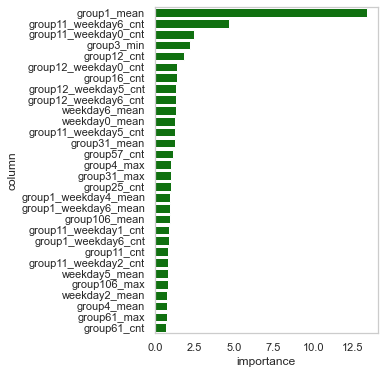

In [240]:
fig, axs = plt.subplots(figsize=(4, 6))

sns.barplot(x='importance',
            y='column',
            orient='h',
            color='green',
            data=importances.head(30))

In [241]:
y_pred = model.predict(X_valid)[:, 0]

In [242]:
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.50      0.51      2255
           1       0.69      0.71      0.70      2229
           2       0.74      0.80      0.77      2293
           3       0.53      0.49      0.51      2223

    accuracy                           0.63      9000
   macro avg       0.62      0.63      0.62      9000
weighted avg       0.62      0.63      0.62      9000



In [243]:
cm=metrics.confusion_matrix(y_valid, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# for i, r in enumerate(cm_norm):
#     r[i] = 0

<AxesSubplot:>

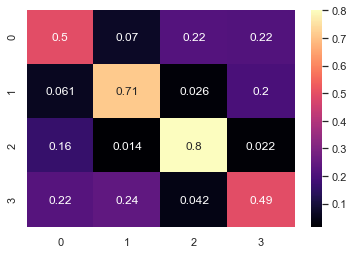

In [244]:
sns.heatmap(cm_norm, annot=True, cmap='magma')

## Clusterization

Кластеризация пользователей на основе handmade признаков обоснование выбора признаков с использованием EDA. Кластеризация пользователей любым способом, который кажется пригодным(с учетом особенностей данных). Визуализация категорий пользователей с использованием алгоритмов понижения размерности данных.

In [120]:
from sklearn.preprocessing import StandardScaler

In [59]:
# takes one minute on my pc
corr_df = client_df.corr()

In [320]:
cols = corr_df.columns
mask = (np.abs(corr_df.to_numpy()) > 0.5) & (np.abs(corr_df.to_numpy()) < 0.8)
for i, j in zip(*np.where(mask)):
    if i != j:
#         pass
#        print(cols[i], cols[j], corr_df.iloc[i, j])

group2_cnt group55_cnt 0.5157280497548121
group4_cnt group4_weekday0_cnt 0.7521527662572361
group4_cnt group4_weekday6_cnt 0.7876451406080373
group5_cnt group5_weekday6_cnt 0.7679696810282229
group5_cnt group5_weekday0_cnt 0.7510093284385643
group8_cnt group8_weekday5_cnt 0.7072965881197073
group8_cnt group8_weekday1_cnt 0.66280702959732
group8_cnt group8_weekday4_cnt 0.6850726581445368
group8_cnt group8_weekday3_cnt 0.6877618390520956
group8_cnt group8_weekday6_cnt 0.7116948306464124
group8_cnt group8_weekday0_cnt 0.7000257140163494
group8_cnt group8_weekday2_cnt 0.6848202350726251
group9_cnt group9_weekday0_cnt 0.7653059568289954
group9_cnt group9_weekday6_cnt 0.7691086993822801
group10_cnt group10_weekday6_cnt 0.6558569479486047
group10_cnt group10_weekday1_cnt 0.7516189431940007
group10_cnt group10_weekday3_cnt 0.7570808306488862
group10_cnt group10_weekday0_cnt 0.6348728994006319
group10_cnt group10_weekday4_cnt 0.7498202038753105
group10_cnt group10_weekday2_cnt 0.751369693084888

group21_weekday1_cnt group21_weekday2_cnt 0.6514860796764368
group21_weekday1_cnt group21_weekday3_cnt 0.69572983043755
group25_weekday1_cnt group25_weekday0_cnt 0.5579844048670538
group25_weekday1_cnt group25_weekday6_cnt 0.6221562208813889
group54_weekday1_cnt group54_cnt 0.7755545184660034
group54_weekday1_cnt group54_weekday2_cnt 0.5255755703785039
group54_weekday1_cnt group54_weekday3_cnt 0.6445514149793137
group54_weekday1_cnt group54_weekday4_cnt 0.5686962577929766
group54_weekday1_cnt group54_weekday5_cnt 0.6371394867479478
group72_weekday1_cnt group72_cnt 0.7228466653076207
group72_weekday1_cnt group72_weekday2_cnt 0.522650136009868
group72_weekday1_cnt group72_weekday3_cnt 0.5350412923396789
group106_weekday1_cnt group106_cnt 0.7724515393307996
group106_weekday1_cnt group106_weekday4_cnt 0.6232626048031462
group106_weekday1_cnt group106_weekday5_cnt 0.5467448851905838
group106_weekday1_cnt group106_weekday2_cnt 0.633470520357396
group106_weekday1_cnt group106_weekday3_cnt 0.6

group57_weekday1_cnt group57_weekday2_cnt 0.764785005628711
group72_weekday4_cnt group72_cnt 0.7762994442349435
group72_weekday4_cnt group72_weekday2_cnt 0.506531189851247
group72_weekday4_cnt group72_weekday5_cnt 0.5844826898662678
group72_weekday4_cnt group72_weekday3_cnt 0.556441375990029
group57_weekday5_cnt group57_weekday0_cnt 0.634654290574298
group57_weekday5_cnt group57_weekday3_cnt 0.7653699497060168
group57_weekday5_cnt group57_weekday6_cnt 0.6515454888986605
group57_weekday5_cnt group57_weekday1_cnt 0.7440982198224159
group57_weekday5_cnt group57_weekday4_cnt 0.7634865009409105
group57_weekday5_cnt group57_weekday2_cnt 0.7475868398050388
group26_weekday6_cnt group26_weekday0_cnt 0.7276472466584517
group26_weekday6_cnt group26_weekday4_cnt 0.6402390585999953
group26_weekday6_cnt group26_weekday5_cnt 0.6560634715264775
group26_weekday6_cnt group26_weekday1_cnt 0.6326938703866453
group26_weekday6_cnt group26_weekday2_cnt 0.6394029896970573
group26_weekday6_cnt group26_weekday3

group5_mean group5_max 0.7660150112741358
group5_mean group5_min 0.736334462582891
group9_mean group9_weekday1_mean 0.5204123143140971
group9_mean group9_weekday6_mean 0.5536575699403973
group9_mean group9_weekday5_mean 0.5359500405530407
group9_mean group9_max 0.7387138146215257
group10_mean group10_min 0.7965377387465223
group11_mean group11_weekday1_mean 0.5458122816393073
group11_mean group11_weekday2_mean 0.5246342929572103
group11_mean group11_weekday3_mean 0.526152934190013
group11_mean group11_weekday4_mean 0.7350507274982887
group11_mean group11_weekday5_mean 0.609626137192412
group11_mean group11_weekday6_mean 0.6199579824095452
group11_mean group11_max 0.5689278758993542
group11_mean group11_min 0.5216555805687935
group12_mean group12_max 0.6981687789152544
group13_mean group13_weekday6_mean 0.5152901708944772
group13_mean group13_max 0.7167962558329302
group13_mean group13_min 0.6413576535781673
group14_mean group14_weekday1_mean 0.5727876189930287
group15_mean group15_week

group82_weekday5_mean group82_weekday2_mean 0.7304515271004305
group82_weekday5_mean group82_weekday4_mean 0.7756474693931362
group82_weekday5_mean group82_weekday6_mean 0.7719010919370209
group82_weekday6_mean group82_mean 0.7142509947356881
group82_weekday6_mean group82_weekday0_mean 0.6790526767362931
group82_weekday6_mean group82_weekday1_mean 0.7870458055015924
group82_weekday6_mean group82_weekday2_mean 0.7601441421417824
group82_weekday6_mean group82_weekday3_mean 0.7496815001752077
group82_weekday6_mean group82_weekday5_mean 0.7719010919370209
group106_weekday4_mean group106_mean 0.6200028897937688
group106_weekday4_mean group106_max 0.6314412095871595
group0_weekday0_mean group0_mean 0.5620023326230618
group0_weekday0_mean group0_max 0.5854505727405587
group0_weekday3_mean group0_mean 0.5130298797785111
group0_weekday3_mean group0_max 0.5149916394793544
group0_weekday4_mean group0_max 0.5358270033936413
group19_weekday5_mean group19_mean 0.5478315703268017
group19_weekday5_mea

group36_max group5_weekday1_mean 0.7458782691838791
group36_max group80_weekday5_mean 0.5922042192471337
group36_max group21_weekday0_mean 0.744575380615574
group36_max group21_max 0.6868851796281611
group36_max group24_max 0.7488707406459135
group36_max group80_max 0.6510124625966724
group37_max group37_mean 0.6923857779514292
group37_max group37_weekday1_mean 0.5293134860537698
group37_max group37_weekday4_mean 0.6547654875262645
group37_max group37_weekday5_mean 0.6073613609173457
group37_max group37_weekday0_mean 0.6769314736165377
group39_max group80_mean 0.5207394361784274
group39_max weekday2_mean 0.5009177655888883
group39_max group39_weekday2_mean 0.5706977637333592
group39_max group39_weekday4_mean 0.7392351914914965
group39_max group39_weekday5_mean 0.6650869452789057
group39_max group39_weekday6_mean 0.5847211698056166
group39_max group39_weekday0_mean 0.5757478087527534
group39_max group39_weekday3_mean 0.5272265889130676
group39_max group80_weekday5_mean 0.593325555550841

no any non-obvious correlation

In [175]:
X = client_df.drop('bins', axis=1)

### PCA

In [122]:
from sklearn.decomposition import PCA

In [123]:
pca = PCA(n_components=X.shape[1])
X_red = pca.fit_transform(X)

In [124]:
cum_var = np.cumsum(pca.explained_variance_ratio_)

<AxesSubplot:>

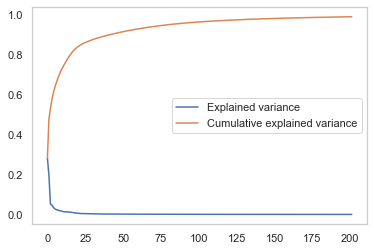

In [323]:
expl_var = pca.explained_variance_ratio_[cum_var < 0.99]
sns.lineplot(x=list(range(len(expl_var))), y=expl_var, label='Explained variance')
sns.lineplot(x=list(range(len(expl_var))), y=cum_var[cum_var < 0.99], label='Cumulative explained variance')

probably take first 50 components if need to reduce dimensionality

In [126]:
X_red = X_red[:, :2]

In [127]:
df_to_plot = pd.DataFrame(X_red, columns=['PC1', 'PC2'])
df_to_plot.index = client_df.index
df_to_plot['bins'] = client_df['bins'].astype(str)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

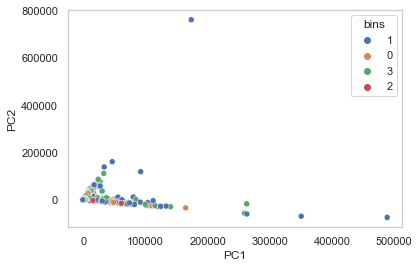

In [128]:
sns.scatterplot(x='PC1', y='PC2', hue='bins', data=df_to_plot)

remove outliers

TODO: maybe explore original dataset for outliers

In [129]:
df_to_plot = df_to_plot[(df_to_plot['PC1'] < 150000) & (df_to_plot['PC2'] < 220000)]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

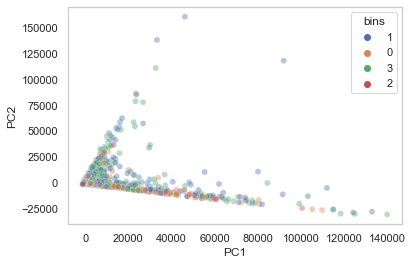

In [130]:
sns.scatterplot(
    x='PC1', y='PC2',hue='bins',
    data=df_to_plot,
    alpha=0.4)

not so evident...

### t-SNE

might have to use cuml

https://docs.rapids.ai/api/cuml/stable/api.html#cuml.TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(
    n_components=2,
    random_state=228,
    n_iter=250,
    verbose=228)
X_tsne = tsne.fit_transform(X)

### UMAP

In [147]:
from umap import UMAP

In [252]:
X_scaled = StandardScaler().fit_transform(X)

In [333]:
umap = UMAP(
    n_components=2,
    init='random',
    min_dist=0.5,
    random_state=228)

In [334]:
# takes 20 seconds on my pc
X_umap = umap.fit_transform(X_scaled)

In [335]:
df_to_plot = pd.DataFrame(X_umap, columns=['x', 'y'])
df_to_plot['bins'] = client_df['bins'].astype(str)

Text(0.5, 1.0, 'UMAP embedding of the clients')

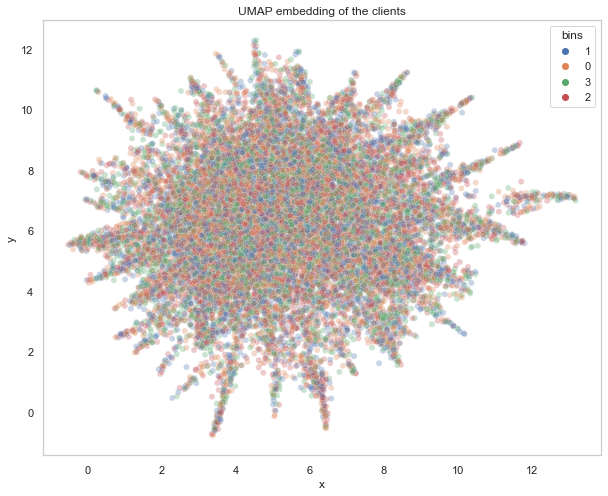

In [336]:
fig, axs = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    x='x', y='y', hue='bins',
    data=df_to_plot,
    alpha=0.3)

plt.title("UMAP embedding of the clients")

In [337]:
df_to_plot_umap = df_to_plot.copy()

In [ ]:
# TODO: play with min distance

### K-Means

In [257]:
from sklearn.cluster import KMeans

In [258]:
# 1 min 36 sec
inertia = []
ks = range(2, 23, 5)
for k in ks:
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_scaled)
    inertia.append(np.sqrt(kmeans.inertia_))

2
7
12
17
22


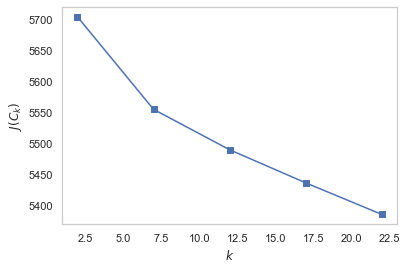

In [259]:
plt.plot(ks, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

4 clusters

In [342]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(X_scaled)

In [343]:
pd.Series(kmeans.labels_).value_counts()

2    14914
3    10084
1     4739
0      263
dtype: int64

In [344]:
# take umap
df_to_plot = pd.DataFrame(X_umap, columns=['x', 'y'])
df_to_plot['bins'] = client_df['bins'].astype(str)
df_to_plot['k-label'] = kmeans.labels_
df_to_plot['k-label'] = df_to_plot['k-label'].astype(str)

In [345]:
df_to_plot_not_scaled = df_to_plot.copy()

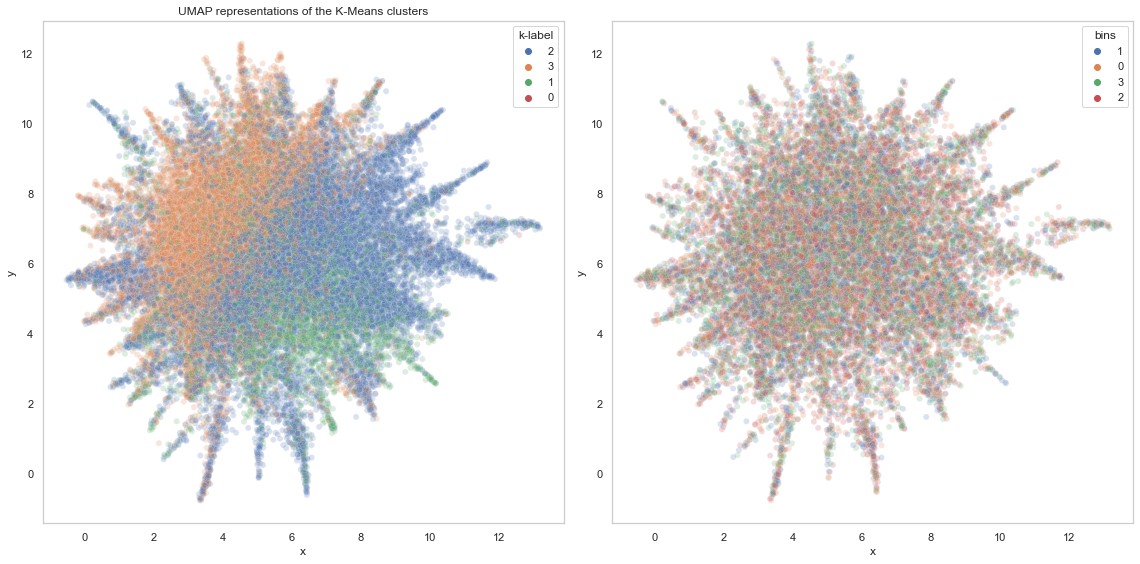

In [346]:
fig, axs = plt.subplots(figsize=(16, 8))

plt.subplot(1, 2, 1)

sns.scatterplot(
    x='x', y='y', hue='k-label',
    data=df_to_plot,
    alpha=0.2)
plt.title('UMAP representations of the K-Means clusters')

plt.subplot(1, 2, 2)

sns.scatterplot(
    x='x', y='y', hue='bins',
    data=df_to_plot_umap,
    alpha=0.2)

fig.tight_layout()

clusters are tight unlike age bins

**take weights from catboost for k-means**

In [289]:
X_scaled.shape

(30000, 1112)

In [295]:
X_ft_scaled = X_scaled * cb_imp['importance'].to_numpy()

In [297]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(X_ft_scaled)

In [298]:
pd.Series(kmeans.labels_).value_counts()

0    19219
1     9205
2     1422
3      154
dtype: int64

In [299]:
df_to_plot = pd.DataFrame(X_umap, columns=['x', 'y'])
df_to_plot['bins'] = client_df['bins'].astype(str)
df_to_plot['k-label'] = kmeans.labels_
df_to_plot['k-label'] = df_to_plot['k-label'].astype(str)

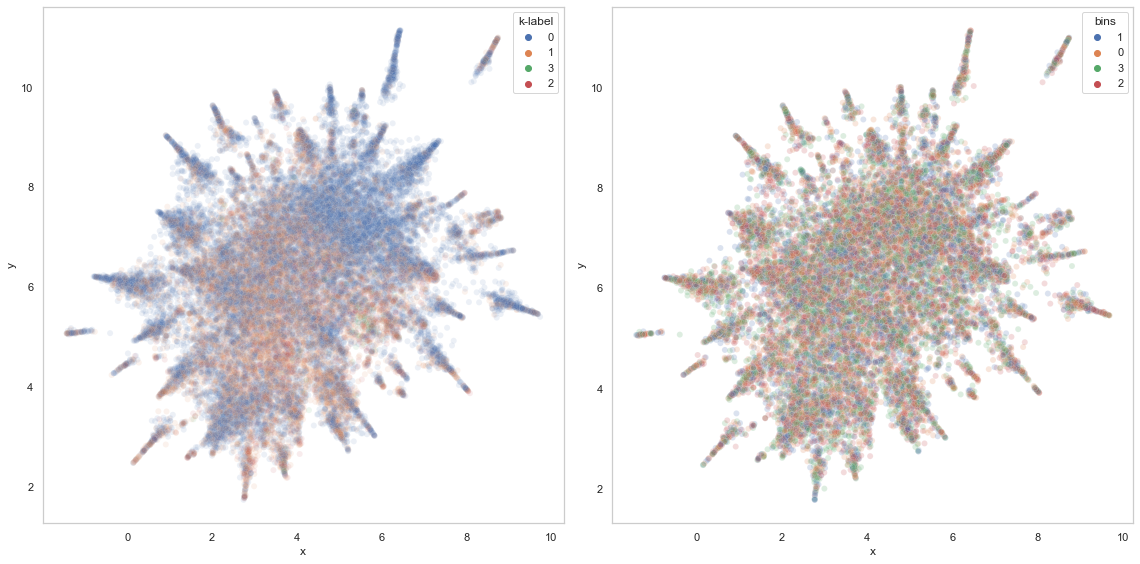

In [301]:
fig, axs = plt.subplots(figsize=(16, 8))

plt.subplot(1, 2, 1)

sns.scatterplot(
    x='x', y='y', hue='k-label',
    data=df_to_plot,
    alpha=0.1)

plt.subplot(1, 2, 2)

sns.scatterplot(
    x='x', y='y', hue='bins',
    data=df_to_plot_umap,
    alpha=0.2)

fig.tight_layout()

**TODO: maybe cuML**
https://docs.rapids.ai/api/cuml/stable/